# Thapar Summer School - Employee Salary Prediction

In this lab, we are predict the salaries of employee from different fake companies.

Here, the features are explain below:

- `id`: Identity of the employee
- `salary`: (Target Column) Salary of the employee
- `company`: Current Company of the employee
- `department`: Department of the employee
- `age`: Current age of the employee
- `age_when_joined`: Employee's age when joined the company
- `year_in_the_company`: Employee's experience in the company
- `prior_years_experience`: Employee's experience prior to joining the company
- `annual_bonus`: Annual bonus of employee

## 1. Tools

Now, before we get, let's initialize some important's libraries.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt

## 2. Viewing the data

Taking a look in our training dataset and getting more familiar with it. Remember that the training dataset and test dataset are already separated.

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Looking at the first five examples of the dataset.

In [3]:
df_train.head()

,id,company,department,age,age_when_joined,years_in_the_company,salary,annual_bonus,prior_years_experience,full_time,part_time,contractor
0,1,Cheerper,Support,40,36,4,69420.46872,22586.99591,2,0.000000,0.893809,0.328591
1,2,Cheerper,BigData,40,34,6,88407.04974,18676.07837,3,0.205947,0.756632,0.036870
2,3,Pear,Sales,41,39,2,97831.84885,19287.87365,2,0.942309,0.000000,0.514457
3,4,Glasses,Search Engine,39,33,6,93905.86813,17936.39297,3,0.484373,0.236922,0.278535
4,5,Glasses,AI,39,35,3,105983.97520,16854.92943,3,0.835346,0.308958,0.000000


Seeing the shape of our dataset.

In [4]:
n_rows = df_train.shape[0]
n_columns = df_train.shape[1]

print(f"The number of rows is: {n_rows}")
print(f"The number of columns is: {n_columns}")

The number of rows is: 100000
The number of columns is: 12


In [5]:
df_train.dtypes

id                          int64
company                    object
department                 object
age                         int64
age_when_joined             int64
years_in_the_company        int64
salary                    float64
annual_bonus              float64
prior_years_experience      int64
full_time                 float64
part_time                 float64
contractor                float64
dtype: object

Checking if the dataframe has some null value.

In [6]:
df_train.isnull().sum()

id                        0
company                   0
department                0
age                       0
age_when_joined           0
years_in_the_company      0
salary                    0
annual_bonus              0
prior_years_experience    0
full_time                 0
part_time                 0
contractor                0
dtype: int64

That's good. Now, we notice that just two features are categorical (`company` and `department`), while the others are numerical (without considerer `id`). Let's see the different values that each of the two feature contains.

#### Values in _company_ and _department_

In [7]:
df_train['company'].value_counts()

Glasses     47734
Cheerper    28583
Pear        23683
Name: company, dtype: int64

In [8]:
df_train['department'].value_counts()

Search Engine    21915
AI               21642
BigData          15777
Design           15713
Sales            12535
Support          12418
Name: department, dtype: int64

In [9]:
df_train.describe(include=object)

,company,department
count,100000,100000
unique,3,6
top,Glasses,Search Engine
freq,47734,21915


#### Summary measures of each numerical feature

In [10]:
df_train.describe(include=[int, float])

,id,age,age_when_joined,years_in_the_company,salary,annual_bonus,prior_years_experience,full_time,part_time,contractor
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,38.195870,33.537060,4.667780,87389.018245,18582.064815,2.505540,0.383531,0.383279,0.382016
std,28867.657797,6.013073,7.719078,2.531773,28478.542805,4373.431365,1.207222,0.340638,0.339783,0.339621
min,1.000000,30.000000,22.000000,1.000000,40000.000000,9000.000000,1.000000,0.000000,0.000000,0.000000
25%,25000.750000,33.000000,27.000000,3.000000,66027.961360,15448.885482,1.000000,0.016171,0.015702,0.013575
50%,50000.500000,38.000000,33.000000,5.000000,86554.204990,18821.651785,2.000000,0.333278,0.334739,0.331437
75%,75000.250000,43.000000,39.000000,7.000000,107269.920325,22168.522630,3.000000,0.653879,0.650733,0.649338
max,100000.000000,49.000000,48.000000,9.000000,153000.000000,24792.910000,5.000000,1.000000,1.000000,1.000000


For we will start the data pre-processing, we know that categorical features like **company** and **department** have a lower cardinality, which can be managed by some **encoding** techniques. 

Also, we know that the others features (which are numerical) are having **high deviation** values which can lead to bias, overfitting, and can affect the accuracy of the model. So, we can use some different transformation techniques to reduce the deviation between the data-points.

## 3. Data pre-processing

Notice that the column `id` only represents the _index_ of a employee. So, as it appears to be irrelevant to analysis, we can simply **drop the feature**.

In [11]:
df_train = df_train.drop(columns='id')

#### Separating numerical features and categorical features

In [12]:
# taking only numerical features
num_feat = df_train.drop(columns=['company', 'department', 'salary'])

# taking only categorical features
cat_feat = df_train.loc[:, ['company', 'department']]

#### Feature Engineering

We will create one new feature `years_experience`. Let's start from the intuition that, generally, the longer an individual's experience, the higher their salary or the higher their salary will be. Therefore, it will be the intuition that this variable will possibly have a strong relationship with salary.

In [13]:
num_feat['years_experience'] = num_feat['years_in_the_company'] + num_feat['prior_years_experience']
df_test['years_experience'] = df_test['years_in_the_company'] + df_test['prior_years_experience']

#### Processing the categorical features using OneHotEnconder

In [14]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# label encoded values of company and department
enc_df = pd.DataFrame(enc.fit_transform(cat_feat[['company', 'department']]).toarray(), columns=enc.get_feature_names(['company', 'department']))
enc_df.head()

C:\Users\samue\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Feature scaling using StandardScale

Notice that, for example, the numerical feature `annual_bonus` have a large scale of values, so, as not to affect the performance of the model and avoid convergence problems for models based on gradients.

In [15]:
# creating a instance of StandardScaler
scaler = StandardScaler()

# applying StandardScaler only to features
num_feat_norm = scaler.fit_transform(num_feat)

# converting normalized output to a new DataFrame
feat_norm_df = pd.DataFrame(num_feat_norm, columns=num_feat.columns)
feat_norm_df.head()

,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor,years_experience
0,0.300036,0.319073,-0.263761,0.915746,-0.418765,-1.125925,1.502528,-0.157308,-0.451892
1,0.300036,0.059974,0.526203,0.021497,0.409587,-0.521329,1.098805,-1.016274,0.703526
2,0.466341,0.707723,-1.053725,0.161386,-0.418765,1.640396,-1.128018,0.389967,-1.222170
3,0.133731,-0.069576,0.526203,-0.147636,0.409587,0.296040,-0.430738,-0.304698,0.703526
4,0.133731,0.189524,-0.658743,-0.394917,0.409587,1.326385,-0.218732,-1.124837,-0.451892


Taking only the target `salary` of dataframe `df_train` to concat with the others df's.

In [16]:
# taking the target
target_df = df_train.loc[:,'salary']

# concatenating the df's of preprocessed numerical and categorical features
all_features = pd.concat([enc_df, feat_norm_df], axis=1)

# concatening the df's of all features with the target
df_train = pd.concat([all_features, target_df], axis=1)
df_train.head()

,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor,years_experience,salary
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.300036,0.319073,-0.263761,0.915746,-0.418765,-1.125925,1.502528,-0.157308,-0.451892,69420.46872
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.300036,0.059974,0.526203,0.021497,0.409587,-0.521329,1.098805,-1.016274,0.703526,88407.04974
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.466341,0.707723,-1.053725,0.161386,-0.418765,1.640396,-1.128018,0.389967,-1.222170,97831.84885
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.133731,-0.069576,0.526203,-0.147636,0.409587,0.296040,-0.430738,-0.304698,0.703526,93905.86813
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.133731,0.189524,-0.658743,-0.394917,0.409587,1.326385,-0.218732,-1.124837,-0.451892,105983.97520


In [17]:
df_train.shape

(100000, 19)

In [18]:
df_train.dtypes

company_Cheerper            float64
company_Glasses             float64
company_Pear                float64
department_AI               float64
department_BigData          float64
department_Design           float64
department_Sales            float64
department_Search Engine    float64
department_Support          float64
age                         float64
age_when_joined             float64
years_in_the_company        float64
annual_bonus                float64
prior_years_experience      float64
full_time                   float64
part_time                   float64
contractor                  float64
years_experience            float64
salary                      float64
dtype: object

#### Separating X_train | y_train and X_cv | y_cv

Today, we know that there are a variety of regression algorithms and a instead to put our focus in only one of those algorithms, it's would be better have some other dataset to realize a cross validation and use them to evaluate different configurations of model. With that, we be able to choose the better model through some metrics like R2 Score and some error functions.

In [19]:
feat_train, targ_train = df_train.drop(columns='salary'), df_train.loc[:, 'salary']
X_train, X_cv, y_train, y_cv = train_test_split(feat_train, targ_train, test_size=0.2, random_state=0)

In [20]:
print("Dimension of X_train =>", X_train.shape)
print("Dimension of X_cv =>", X_cv.shape)
print("Dimension of y_train =>", y_train.shape)
print("Dimension of y_cv =>", y_cv.shape)

Dimension of X_train => (80000, 18)
Dimension of X_cv => (20000, 18)
Dimension of y_train => (80000,)
Dimension of y_cv => (20000,)


#### Doing all preprocessing to the df of the test and obtaining X_test

In [21]:
# drop id
df_test = df_test.drop(columns='id')

# separate the numerical features and categorical features
num_feat_test = df_test.drop(columns=['company', 'department'])
cat_feat_test = df_test.loc[:, ['company', 'department']]

# OneHotEncoder
enc_test = OneHotEncoder(handle_unknown='ignore')
enc_test_df = pd.DataFrame(enc_test.fit_transform(cat_feat_test[['company', 'department']]).toarray(), columns=enc_test.get_feature_names(['company', 'department']))

# Feature scaling
num_feat_norm_test = scaler.fit_transform(num_feat_test)
feat_norm_df_test = pd.DataFrame(num_feat_norm_test, columns=num_feat_test.columns)

# concatenating the df's of preprocessed numerical and categorical features of test
X_test = pd.concat([enc_test_df, feat_norm_df_test], axis=1)
X_test.head()

C:\Users\samue\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor,years_experience
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.117167,1.859593,-1.442821,-2.176168,1.239771,-1.127529,-0.653535,1.811299,-0.831064
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.452452,1.083241,-1.442821,-0.367324,1.239771,0.254885,-1.126316,0.999501,-0.831064
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.876979,-1.375206,1.718193,-0.898164,1.239771,-0.129338,1.118517,-1.129061,2.256270
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.710800,-0.598855,0.137686,0.977069,-0.415398,1.799037,-1.126316,0.075396,-0.059231
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.618631,0.953849,-1.442821,-0.665359,-0.415398,-1.127529,0.997430,0.616834,-1.602898


In [22]:
X_test.shape

(50000, 18)

## 4. Model Creation & Evaluation

We will create a function to train model using different regression algorithms.

In [23]:
r2_value = []
adjusted_r2_value = []
mae_value = []
mse_value = []
rmse_value = []

In [24]:
def model_evaluation(model):
    model.fit(X_train, y_train)
    y_train_pred= model.predict(X_train)
    y_cv_pred = model.predict(X_cv)

    #Metrics Calculation.
    mae = mean_absolute_error(y_cv,y_cv_pred)
    mse = mean_squared_error(y_cv,y_cv_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_cv,y_cv_pred)
    adjusted_r2 = 1 - ((1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
   
    mae_value.append(mae)
    mse_value.append(mse)
    rmse_value.append(rmse)
    r2_value.append(r2)
    adjusted_r2_value.append(adjusted_r2) 
    
    print(f"R2 Score of the {model} model is=>",r2)
    print(f"Adjusted R2 Score of the {model} model is=>",adjusted_r2)
    print()
    print(f"MAE of {model} model is=>",mae)
    print(f"MSE of {model} model is=>",mse)
    print(f"RMSE of {model} model is=>",rmse)
    

    # Scatter plot.
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)    
    plt.scatter(y_train, y_train_pred, color='blue', label='Train')
    plt.scatter(y_cv, y_cv_pred, color='red', label='Test')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot',fontweight="black",size=20,pad=10)
    
    # Residual plot.
    plt.subplot(1,2,2)
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', label='Train')
    plt.scatter(y_cv_pred, y_cv_pred - y_cv, color='red', label='Test')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.title('Residual Plot',fontweight="black",size=20,pad=10)
    plt.show()

#### Creating a LinearRegression Model

R2 Score of the LinearRegression() model is=> 0.6887258215269034
Adjusted R2 Score of the LinearRegression() model is=> 0.688613720224158

MAE of LinearRegression() model is=> 12731.833628409999
MSE of LinearRegression() model is=> 251846261.07856464
RMSE of LinearRegression() model is=> 15869.6648067489


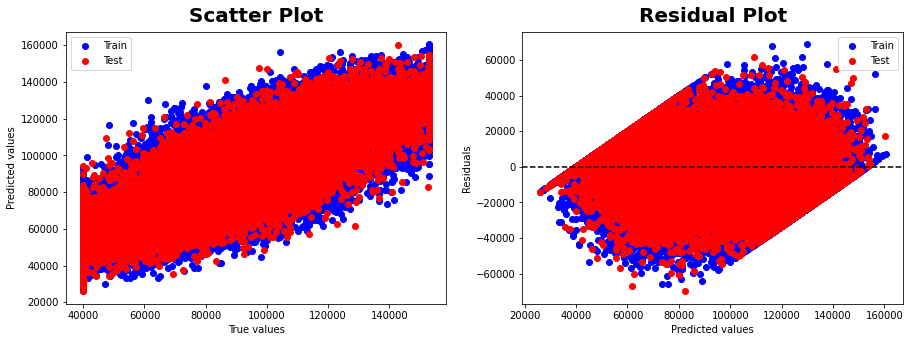

In [25]:
model_evaluation(LinearRegression())

#### Creating a SGDRegressor Model

R2 Score of the SGDRegressor() model is=> 0.6882064155977494
Adjusted R2 Score of the SGDRegressor() model is=> 0.6880941272377878

MAE of SGDRegressor() model is=> 12757.114550615399
MSE of SGDRegressor() model is=> 252266502.94340923
RMSE of SGDRegressor() model is=> 15882.89970198796


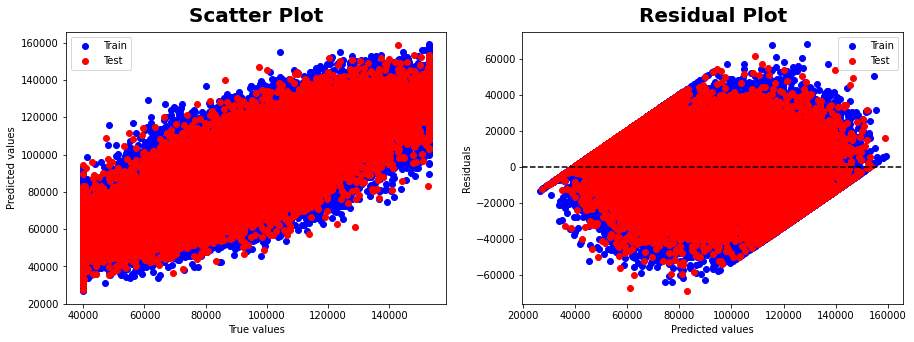

In [26]:
model_evaluation(SGDRegressor(max_iter=1000))

#### Creating a GradientBoostingRegressor Model

R2 Score of the GradientBoostingRegressor() model is=> 0.7168733841317594
Adjusted R2 Score of the GradientBoostingRegressor() model is=> 0.7167714198036022

MAE of GradientBoostingRegressor() model is=> 12169.435173246893
MSE of GradientBoostingRegressor() model is=> 229072581.50359634
RMSE of GradientBoostingRegressor() model is=> 15135.143920808825


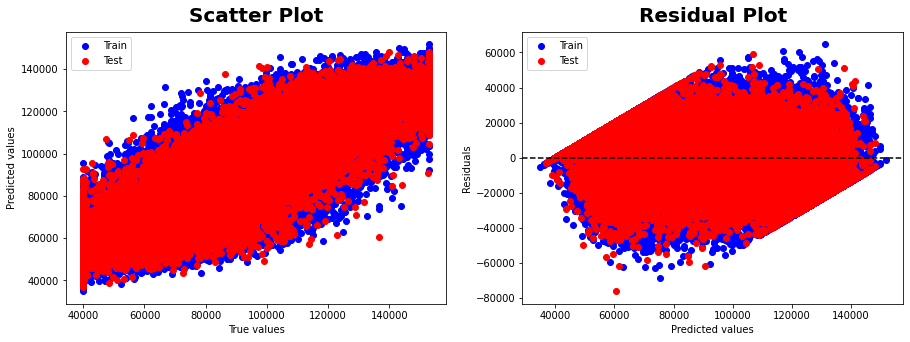

In [27]:
model_evaluation(GradientBoostingRegressor())

#### Creating a RandomForestRegressor Model

R2 Score of the RandomForestRegressor() model is=> 0.7062808673902207
Adjusted R2 Score of the RandomForestRegressor() model is=> 0.7061750883064293

MAE of RandomForestRegressor() model is=> 12275.795745038758
MSE of RandomForestRegressor() model is=> 237642793.622875
RMSE of RandomForestRegressor() model is=> 15415.667148160504


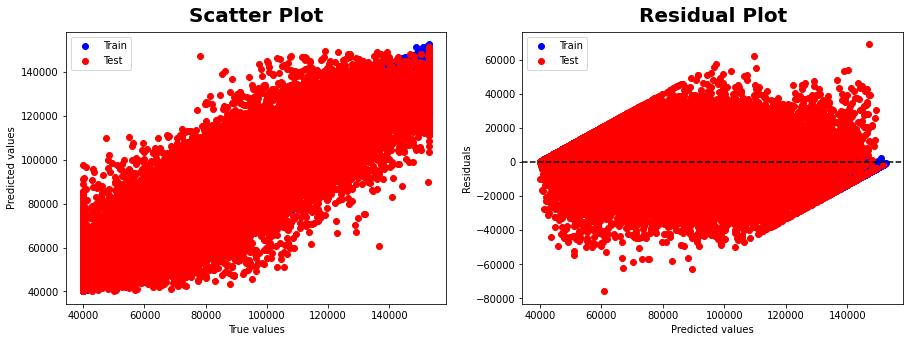

In [28]:
model_evaluation(RandomForestRegressor())

####  Creating a AdaBoostRegressor Model

R2 Score of the AdaBoostRegressor() model is=> 0.6132386050306833
Adjusted R2 Score of the AdaBoostRegressor() model is=> 0.6130993179994224

MAE of AdaBoostRegressor() model is=> 14464.9575127941
MSE of AdaBoostRegressor() model is=> 312921591.2812089
RMSE of AdaBoostRegressor() model is=> 17689.589912748368


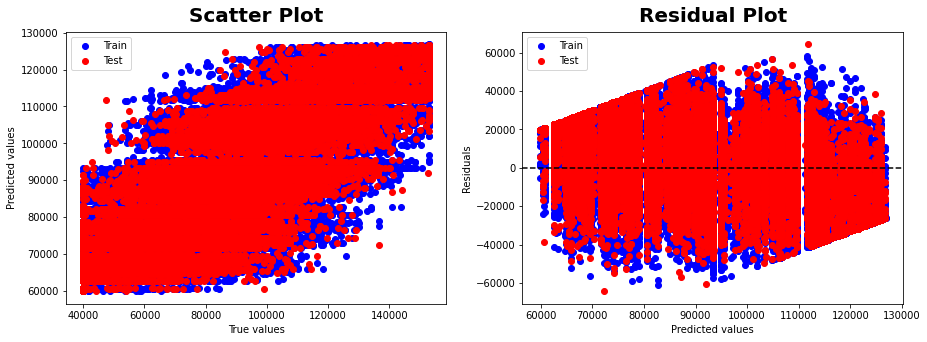

In [29]:
model_evaluation(AdaBoostRegressor())

#### Creating a XGBRegressor Model

R2 Score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) model is=> 0.7266942494109743
Adjusted R2 Score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
    

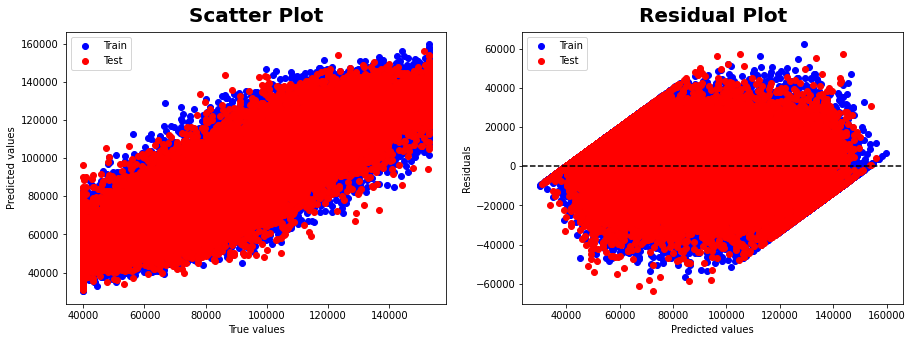

In [30]:
model_evaluation(XGBRegressor())

#### Creating a CatBoostRegressor Model

Learning rate set to 0.081822
0:	learn: 27116.5400737	total: 139ms	remaining: 2m 18s
1:	learn: 25894.8526194	total: 144ms	remaining: 1m 11s
2:	learn: 24820.2309144	total: 149ms	remaining: 49.6s
3:	learn: 23810.6476078	total: 155ms	remaining: 38.6s
4:	learn: 22926.9498371	total: 160ms	remaining: 31.9s
5:	learn: 22137.5480857	total: 166ms	remaining: 27.4s
6:	learn: 21440.9241149	total: 171ms	remaining: 24.3s
7:	learn: 20808.8542087	total: 176ms	remaining: 21.9s
8:	learn: 20259.3663303	total: 181ms	remaining: 20s
9:	learn: 19772.8973580	total: 187ms	remaining: 18.5s
10:	learn: 19342.0143881	total: 193ms	remaining: 17.3s
11:	learn: 18965.2854430	total: 198ms	remaining: 16.3s
12:	learn: 18625.1512287	total: 202ms	remaining: 15.4s
13:	learn: 18331.4573253	total: 207ms	remaining: 14.6s
14:	learn: 18072.0467381	total: 212ms	remaining: 13.9s
15:	learn: 17836.8425480	total: 216ms	remaining: 13.3s
16:	learn: 17624.9307377	total: 221ms	remaining: 12.8s
17:	learn: 17436.5787790	total: 226ms	remaini

172:	learn: 14641.2012296	total: 1.07s	remaining: 5.1s
173:	learn: 14638.0813229	total: 1.07s	remaining: 5.09s
174:	learn: 14636.1014099	total: 1.08s	remaining: 5.08s
175:	learn: 14633.8422587	total: 1.08s	remaining: 5.08s
176:	learn: 14631.3808825	total: 1.09s	remaining: 5.07s
177:	learn: 14628.8097568	total: 1.1s	remaining: 5.07s
178:	learn: 14626.1350134	total: 1.1s	remaining: 5.06s
179:	learn: 14623.8210753	total: 1.11s	remaining: 5.05s
180:	learn: 14621.7568835	total: 1.11s	remaining: 5.04s
181:	learn: 14619.0758807	total: 1.12s	remaining: 5.03s
182:	learn: 14616.4117401	total: 1.12s	remaining: 5.02s
183:	learn: 14614.7002077	total: 1.13s	remaining: 5.01s
184:	learn: 14612.7632730	total: 1.13s	remaining: 5s
185:	learn: 14610.8320088	total: 1.14s	remaining: 4.98s
186:	learn: 14608.7033599	total: 1.14s	remaining: 4.97s
187:	learn: 14605.9369278	total: 1.15s	remaining: 4.96s
188:	learn: 14603.6635536	total: 1.15s	remaining: 4.96s
189:	learn: 14601.5731822	total: 1.16s	remaining: 4.94

338:	learn: 14394.4551914	total: 1.96s	remaining: 3.82s
339:	learn: 14393.3938083	total: 1.97s	remaining: 3.82s
340:	learn: 14392.4790633	total: 1.97s	remaining: 3.81s
341:	learn: 14391.7181455	total: 1.98s	remaining: 3.81s
342:	learn: 14390.6580109	total: 1.98s	remaining: 3.8s
343:	learn: 14389.7127387	total: 1.99s	remaining: 3.8s
344:	learn: 14388.4897600	total: 2s	remaining: 3.79s
345:	learn: 14387.5608685	total: 2s	remaining: 3.79s
346:	learn: 14386.7234666	total: 2.01s	remaining: 3.79s
347:	learn: 14385.7684136	total: 2.02s	remaining: 3.78s
348:	learn: 14384.8276789	total: 2.03s	remaining: 3.78s
349:	learn: 14383.6547522	total: 2.03s	remaining: 3.78s
350:	learn: 14382.3754078	total: 2.04s	remaining: 3.77s
351:	learn: 14381.3516552	total: 2.05s	remaining: 3.77s
352:	learn: 14380.4535674	total: 2.05s	remaining: 3.76s
353:	learn: 14379.4875683	total: 2.06s	remaining: 3.76s
354:	learn: 14378.6397829	total: 2.06s	remaining: 3.75s
355:	learn: 14377.8460471	total: 2.07s	remaining: 3.74s


499:	learn: 14254.1437182	total: 2.85s	remaining: 2.85s
500:	learn: 14253.3019741	total: 2.86s	remaining: 2.85s
501:	learn: 14252.6170021	total: 2.87s	remaining: 2.84s
502:	learn: 14251.5489015	total: 2.87s	remaining: 2.84s
503:	learn: 14250.8775097	total: 2.88s	remaining: 2.83s
504:	learn: 14250.2341255	total: 2.88s	remaining: 2.82s
505:	learn: 14249.1743375	total: 2.88s	remaining: 2.82s
506:	learn: 14248.6157183	total: 2.89s	remaining: 2.81s
507:	learn: 14247.8683465	total: 2.9s	remaining: 2.8s
508:	learn: 14247.2301619	total: 2.9s	remaining: 2.8s
509:	learn: 14246.2556168	total: 2.9s	remaining: 2.79s
510:	learn: 14245.2136206	total: 2.91s	remaining: 2.79s
511:	learn: 14244.5514738	total: 2.92s	remaining: 2.78s
512:	learn: 14243.6932304	total: 2.92s	remaining: 2.77s
513:	learn: 14242.6890429	total: 2.92s	remaining: 2.77s
514:	learn: 14242.1040056	total: 2.93s	remaining: 2.76s
515:	learn: 14241.2323100	total: 2.94s	remaining: 2.75s
516:	learn: 14240.3085513	total: 2.94s	remaining: 2.7

666:	learn: 14133.0823701	total: 3.77s	remaining: 1.88s
667:	learn: 14132.2926188	total: 3.77s	remaining: 1.87s
668:	learn: 14131.5512538	total: 3.78s	remaining: 1.87s
669:	learn: 14130.8791710	total: 3.78s	remaining: 1.86s
670:	learn: 14130.3420838	total: 3.79s	remaining: 1.86s
671:	learn: 14129.6739755	total: 3.79s	remaining: 1.85s
672:	learn: 14129.0184956	total: 3.8s	remaining: 1.85s
673:	learn: 14128.5055474	total: 3.81s	remaining: 1.84s
674:	learn: 14127.8134256	total: 3.81s	remaining: 1.83s
675:	learn: 14126.9216778	total: 3.82s	remaining: 1.83s
676:	learn: 14126.1466270	total: 3.82s	remaining: 1.82s
677:	learn: 14125.6923668	total: 3.83s	remaining: 1.82s
678:	learn: 14125.0264930	total: 3.83s	remaining: 1.81s
679:	learn: 14124.5204269	total: 3.84s	remaining: 1.8s
680:	learn: 14123.8448357	total: 3.84s	remaining: 1.8s
681:	learn: 14122.9163713	total: 3.85s	remaining: 1.79s
682:	learn: 14122.2096457	total: 3.85s	remaining: 1.79s
683:	learn: 14121.6312275	total: 3.86s	remaining: 1

839:	learn: 14018.3112688	total: 4.66s	remaining: 887ms
840:	learn: 14017.6148560	total: 4.66s	remaining: 882ms
841:	learn: 14017.0090952	total: 4.67s	remaining: 876ms
842:	learn: 14016.4690954	total: 4.67s	remaining: 871ms
843:	learn: 14016.0811528	total: 4.68s	remaining: 865ms
844:	learn: 14015.6496412	total: 4.68s	remaining: 860ms
845:	learn: 14015.0164895	total: 4.69s	remaining: 854ms
846:	learn: 14014.3519789	total: 4.7s	remaining: 848ms
847:	learn: 14013.6804441	total: 4.7s	remaining: 843ms
848:	learn: 14012.9738868	total: 4.71s	remaining: 837ms
849:	learn: 14012.3499880	total: 4.71s	remaining: 831ms
850:	learn: 14011.6901253	total: 4.72s	remaining: 826ms
851:	learn: 14011.0722857	total: 4.72s	remaining: 820ms
852:	learn: 14010.4213151	total: 4.73s	remaining: 814ms
853:	learn: 14009.9589929	total: 4.73s	remaining: 809ms
854:	learn: 14009.4444323	total: 4.74s	remaining: 803ms
855:	learn: 14008.8877382	total: 4.74s	remaining: 798ms
856:	learn: 14008.3613749	total: 4.75s	remaining: 

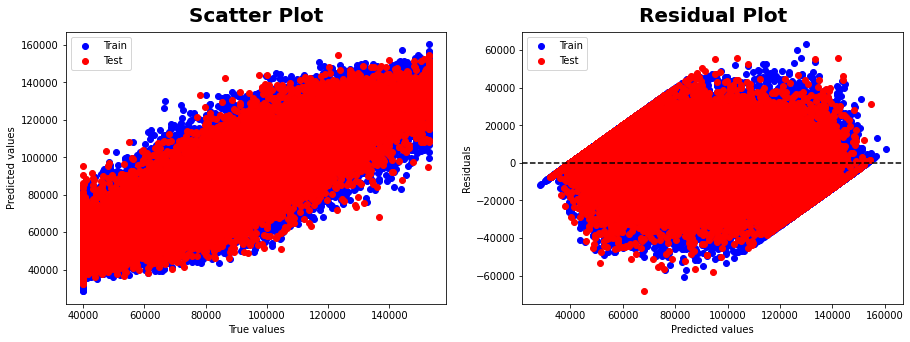

In [31]:
model_evaluation(CatBoostRegressor())

#### Creating a Neural Network Model

In [32]:
X_train.keys()

Index(['company_Cheerper', 'company_Glasses', 'company_Pear', 'department_AI',
       'department_BigData', 'department_Design', 'department_Sales',
       'department_Search Engine', 'department_Support', 'age',
       'age_when_joined', 'years_in_the_company', 'annual_bonus',
       'prior_years_experience', 'full_time', 'part_time', 'contractor',
       'years_experience'],
      dtype='object')

In [44]:
# creating a network
def build_model():
    model = Sequential([
    Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
  ])
    # We will use a mean squared error loss and an Adam optimizer.
    optimizer = tf.keras.optimizers.Adam(0.005)
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               2432      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 35,585
Trainable params: 35,585
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Shows training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

# The patience parameter is the number of epochs to check the improvements
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.2, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Epoch 1/100
2000/2000 [==============================] - 3s 1ms/step - loss: 454265760.0000 - mae: 14824.0889 - mse: 454265760.0000 - val_loss: 242240944.0000 - val_mae: 12476.6680 - val_mse: 242240944.0000
Epoch 2/100
2000/2000 [==============================] - 2s 1ms/step - loss: 245914848.0000 - mae: 12558.6289 - mse: 245914848.0000 - val_loss: 253064416.0000 - val_mae: 12650.4482 - val_mse: 253064416.0000
Epoch 3/100
2000/2000 [==============================] - 2s 1ms/step - loss: 240267904.0000 - mae: 12401.5195 - mse: 240267904.0000 - val_loss: 232041488.0000 - val_mae: 12196.2754 - val_mse: 232041488.0000
Epoch 4/100
2000/2000 [==============================] - 3s 1ms/step - loss: 236762384.0000 - mae: 12295.3486 - mse: 236762384.0000 - val_loss: 227788144.0000 - val_mae: 12085.8467 - val_mse: 227788144.0000
Epoch 5/100
2000/2000 [==============================] - 3s 1ms/step - loss: 235462112.0000 - mae: 12262.7822 - mse: 235462112.0000 - val_loss: 247299328.0000 - val_mae: 12

Epoch 40/100
2000/2000 [==============================] - 2s 1ms/step - loss: 218671472.0000 - mae: 11793.5488 - mse: 218671472.0000 - val_loss: 219627840.0000 - val_mae: 11750.7783 - val_mse: 219627840.0000
Epoch 41/100
2000/2000 [==============================] - 2s 1ms/step - loss: 218103744.0000 - mae: 11777.0381 - mse: 218103744.0000 - val_loss: 220659472.0000 - val_mae: 11859.8877 - val_mse: 220659472.0000
Epoch 42/100
2000/2000 [==============================] - 2s 1ms/step - loss: 218355488.0000 - mae: 11787.4980 - mse: 218355488.0000 - val_loss: 216003184.0000 - val_mae: 11700.7031 - val_mse: 216003184.0000
Epoch 43/100
2000/2000 [==============================] - 2s 1ms/step - loss: 218256304.0000 - mae: 11786.7100 - mse: 218256304.0000 - val_loss: 216848864.0000 - val_mae: 11757.0781 - val_mse: 216848864.0000
Epoch 44/100
2000/2000 [==============================] - 2s 1ms/step - loss: 217909456.0000 - mae: 11768.1582 - mse: 217909456.0000 - val_loss: 219003936.0000 - val_ma

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
51,216967360.0,11744.241211,216967360.0,226555856.0,12050.791992,226555856.0,51
52,217134400.0,11745.948242,217134400.0,219014480.0,11748.922852,219014480.0,52
53,216601616.0,11740.122070,216601616.0,220815136.0,11781.767578,220815136.0,53
54,216647328.0,11728.301758,216647328.0,219329408.0,11796.003906,219329408.0,54
55,216877984.0,11747.241211,216877984.0,216805520.0,11721.521484,216805520.0,55


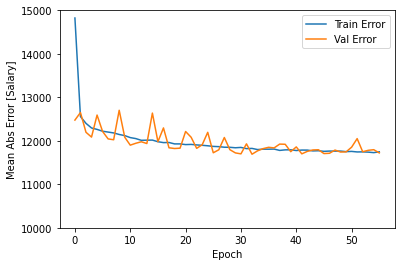

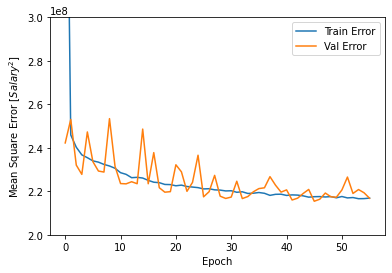

In [47]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Salary]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([1e4,1.5e4])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Salary^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([2e8,3e8])
    plt.legend()
    plt.show()


plot_history(history)

## 5. Model's performance comparison

Let's take a look and compare the results of each model through of metrics.

In [37]:
algorithms = ["LinearRegression", "SGDRegresor","RandomForestRegresor","AdaBoostRegressor","GradientBosstRegressor", 
              "XGBosstRegressor","CatBoostRegressor"]

In [38]:
model_metrics = pd.DataFrame({"Model":algorithms,"R2_Score":r2_value,"Adjusted_R2_Score":adjusted_r2_value,
                       "MAE":mae_value,"MSE":mse_value,"RMSE":rmse_value})

model_metrics

,Model,R2_Score,Adjusted_R2_Score,MAE,MSE,RMSE
0,LinearRegression,0.688726,0.688614,12731.833628,2.518463e+08,15869.664807
1,SGDRegresor,0.688206,0.688094,12757.114551,2.522665e+08,15882.899702
2,RandomForestRegresor,0.716873,0.716771,12169.435173,2.290726e+08,15135.143921
3,AdaBoostRegressor,0.706281,0.706175,12275.795745,2.376428e+08,15415.667148
4,GradientBosstRegressor,0.613239,0.613099,14464.957513,3.129216e+08,17689.589913
5,XGBosstRegressor,0.726694,0.726596,11869.406663,2.211267e+08,14870.329469
6,CatBoostRegressor,0.736481,0.736386,11652.456611,2.132085e+08,14601.661027


We can see that the best performing is given to **CatBoostRegressor**, with highest **R2 and Adjusted R2 Score** and lowest **MAE and MSE**. So, we can use and we will use them to predict the employee's salary. 

We also know that although XGBoost is the **second best performance** regression model, the network we train still does **better** and consequently better than all the others, except in relation to CatBoost.

Therefore, before of we using the CatBoost and the Neural Network to predict the data, let's **tunning the hyper paramaters** of CatBoost.

## 6. Model Hyper-parameter tunning

### Hyper-parameter tunning of CatBoost

In [39]:
catboost_model = CatBoostRegressor(verbose=False)

# defining some parameters
parameters_init = {"n_estimators":[50,100,150],
                   "random_state":[0,42,50],
                   "learning_rate":[0.1,0.3,0.5,1.0]}

# Applying the technique of GridSearch to find the best parameters
grid_search = GridSearchCV(catboost_model, parameters_init , cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001FF804CB2E0>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 1.0],
                         'n_estimators': [50, 100, 150],
                         'random_state': [0, 42, 50]})

In [40]:
# Let's see the best parameters
best_parameters = grid_search.best_params_
best_parameters

{'learning_rate': 0.3, 'n_estimators': 150, 'random_state': 42}

#### Creating a CatBoost model with the best parameters

In [41]:
catboost_model_tunning = CatBoostRegressor(**best_parameters, verbose=False)

# Training the model
catboost_model_tunning.fit(X_train,y_train)

In [43]:
# Prediction with the new catboost model
y_pred = catboost_model_tunning.predict(X_cv)

# Compute some metrics
print("R2_Score of model is:",r2_score(y_cv,y_pred))
print("RMSE Score of model is:",np.sqrt(mean_squared_error(y_cv,y_pred)))
print("Adjusted_R2_Score of model is:",1-((1-r2_score(y_cv,y_pred))*(X_cv.shape[0]-1)/(X_cv.shape[0]-X_cv.shape[1]-1)))

R2_Score of model is: 0.7344274697399396
RMSE Score of model is: 14658.440946186121
Adjusted_R2_Score of model is: 0.7341882271822757


## 7. Predicting test dataset using the best model

In [48]:
CB_predictions = catboost_model_tunning.predict(X_test)

In [50]:
submission = pd.read_csv('sample-submission.csv')

In [51]:
submission.head()

,id,salary
0,1,100.0
1,2,100.0
2,3,100.0
3,4,100.0
4,5,100.0


In [52]:
submission['salary'] = CB_predictions
submission

,id,salary
0,1,55995.103296
1,2,91218.401487
2,3,57867.515485
3,4,124519.642602
4,5,61649.909076
...,...,...
49995,49996,84876.265226
49996,49997,70481.671072
49997,49998,97365.897641
49998,49999,55883.374404


In [56]:
# To send the model prediction
submission.to_csv('submission_example.csv', index=False)

#### 7.1 Viewing the prediction with the neural network

625/625 [==============================] - 0s 551us/step


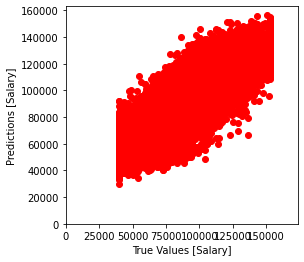

In [58]:
net_predictions = model.predict(X_cv).flatten()

plt.scatter(y_cv, net_predictions, color='r')
plt.xlabel('True Values [Salary]')
plt.ylabel('Predictions [Salary]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

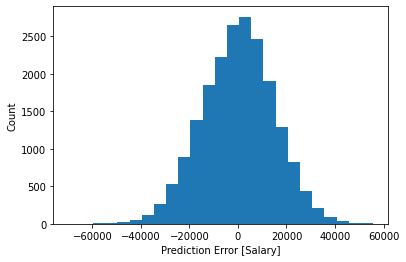

In [59]:
error = net_predictions - y_cv
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Salary]")
_ = plt.ylabel("Count")

Notice that the error follows a gaussian.

In [60]:
net_predict = model.predict(X_test).flatten()
submission2 = pd.read_csv('sample-submission.csv')

submission2['salary'] = net_predict
submission2

1563/1563 [==============================] - 1s 551us/step


,id,salary
0,1,53870.210938
1,2,95907.406250
2,3,58433.371094
3,4,130208.164062
4,5,59064.976562
...,...,...
49995,49996,80724.820312
49996,49997,73888.351562
49997,49998,109196.382812
49998,49999,44732.492188
